In [5]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.table import Table
from healpy.newvisufunc import projview


np.set_printoptions(precision=6, suppress=True, threshold=20)

In [6]:
x_ray_quasars_path = "../Products/Tables/matched_quaia.csv"
x_ray_quasars = Table.read(x_ray_quasars_path)
print(f"Number of Quasars: {len(x_ray_quasars)}")

x_ray_quasars[0:5]

Number of Quasars: 40511


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693468093872,0.0,1.5508954797488483e-12,2317512508372225024,0.282,0.1090472537279129
1eRASS J012338.1-231059,102111400001,20.90908484230626,-23.183134713205,1.2023203372955322,0.0,1.1919692663453496e-11,5041410282510663168,0.39622849225997925,0.13338495750904084
1eRASS J020037.2-164905,103010800001,30.155090369271388,-16.818333184496638,0.6730599999427795,0.0,2.485978436994607e-12,5141673064220360320,0.3344,0.14063352643013
1eRASS J020457.6-170120,103010800003,31.240058066010775,-17.022440181196895,0.9719955325126648,0.0,1.14751871199692e-12,5144596631278605568,1.447,0.2130942321014404
1eRASS J022028.0-130518,103510200005,35.11680749761765,-13.088525812836975,1.4507052898406982,0.0,6.194454671426541e-13,5150434488266469248,1.4535433053970337,0.12690326545715325


In [7]:
nside = 64
npix = hp.nside2npix(nside)
pixel_indices = hp.ang2pix(nside, x_ray_quasars['RA'], x_ray_quasars['DEC'], lonlat=True)
map_quasars = np.bincount(pixel_indices, minlength=npix)


40511
37895.01035855537
0.8392936452111668


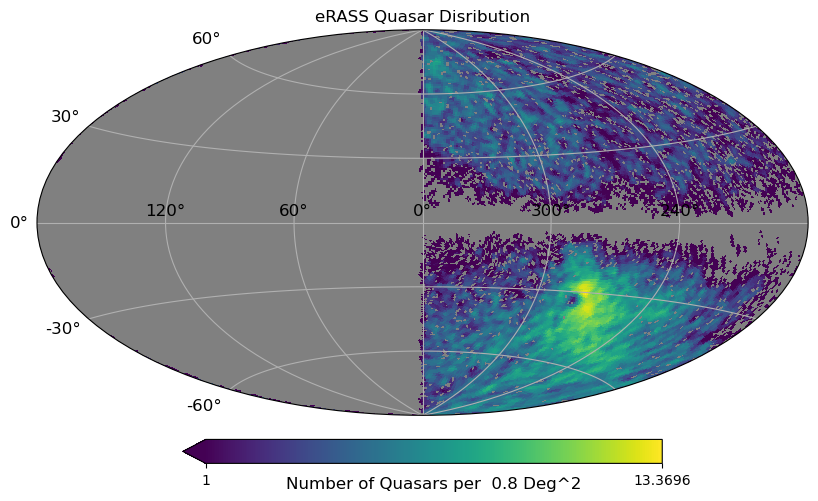

In [8]:
mask = np.zeros(npix, dtype=np.int64)
theta, phi = hp.pix2ang(nside=nside, ipix = np.arange(npix), lonlat=True)
interp_val = hp.get_interp_val(map_quasars, theta, phi, nest=False, lonlat=True)
# print(len(interp_val[interp_val==0]))
mask[interp_val > 0] = 1
smooth_map = mask * hp.smoothing(map_quasars, fwhm=np.radians(2))
# smooth_map = map_quasars
area = hp.nside2pixarea(nside, degrees=True)
print(map_quasars.sum())
print(smooth_map.sum())
smooth_map *= map_quasars.sum() / smooth_map.sum()
# print(smooth_map.sum())
print(area)
projview(smooth_map, coord=['C', 'G'], norm='log', min=1, graticule=True, graticule_labels=True, unit = f"Number of Quasars per {area: 0.1g} Deg^2", cmap="viridis", projection_type="aitoff")
plt.title("eRASS Quasar Disribution")
plt.savefig("../Products/eRASS_Quasar_SkyMap.png", dpi = 200)


In [9]:
import requests

from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord

# initiallise HEALPix map according to eRASS settings
erass_hpix = HEALPix(nside=2**16, order='nested', frame='icrs')

# convert from my pix vals to coordinates (eRASS Requires nested)
theta, phi = hp.pix2ang(nside=nside, ipix = np.arange(npix), lonlat=True, nest=True)
coords = SkyCoord(theta, phi, unit='deg')

# convert these coordinates into corresponding erass IDs
erass_hpix_ids = erass_hpix.skycoord_to_healpix(coords)

# want the 0.2 - 2.3 KeV band
band = '024'

# api URL for 024 band
url = "https://sciserver.mpe.mpg.de/erosita-ul/ULbyHPlist/024/"

# initiallise array for exposure map
exposure_vals = np.zeros(npix)

# there is a cap of 30,000 at a time so split array into 10 smaller arrays
batches = np.array_split(erass_hpix_ids, 10)

# loop through batches
for batch in batches:
    # convert from np array to python list so it can be serialized into json
    batch_list = batch.tolist()
    # send request to API
    req = requests.post(url, json=batch_list)
    # check if successfull (200 = Good)
    print(f"Status Code : {req.status_code}")

    # select data corresponding to the right band
    data = req.json()[band]
        
    # read retreived data into numpy arrays
    # NOTE, not all pix values seem to have exposure values, in these cases default to 0
    hpix_ids = np.array([val.get('healpix', 0) for val in data])
    exposure = np.array([val.get('Exposure', 0) for val in data])

    # some of the id vals get duplicated for some reason? so only select unique ones
    u, idx = np.unique(hpix_ids, return_index=True)
    exposure = exposure[idx]

    # check the returned id aggainst the id we were checking for position in exposure map
    exposure_vals[np.isin(erass_hpix_ids, u)==True] = exposure



Status Code : 200
Status Code : 200
Status Code : 200
Status Code : 200
Status Code : 200
Status Code : 200
Status Code : 200
Status Code : 200
Status Code : 200
Status Code : 200


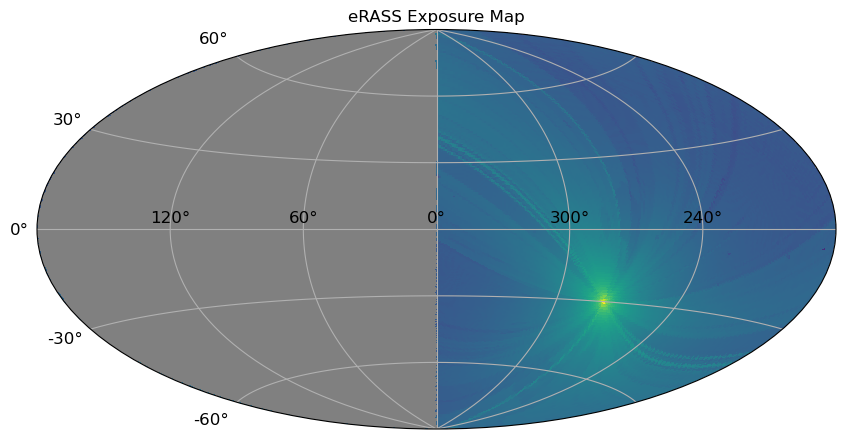

In [10]:
# have to plot exposure map nested
projview(exposure_vals, coord=['C', 'G'], norm='log', min=10, graticule=True, graticule_labels=True, cmap="viridis", projection_type="aitoff", nest=True, cbar=False)
plt.title('eRASS Exposure Map')
plt.savefig("../Products/eRASS_Exposure_map.png",dpi=200)
plt.show()

In [16]:
# save exposure_map vals to file so I don't have to retrieve them everytime.
np.savetxt("../Products/Exposure_map.csv", exposure_vals, delimiter=',', header = f"# Coord = 'C' , Nested = True , nside = {nside}", fmt = "%.8f")